In [1]:
#import library
import pandas as pd
import numpy as np
import re
import string

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional
from keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import gensim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

In [2]:
import tensorflow as tf
print(tf.__version__)

2.10.1


# Proses Text

In [3]:
#Input data
df = pd.read_csv('Dataset Twitter Fix - Indonesian Sentiment Twitter Dataset Labeled (1).csv')
df = df[['sentimen', 'Tweet']]


In [4]:
df['sentimen'].value_counts()

sentimen
0.0    5327
2.0    4188
1.0    2792
4.0     152
6.0     100
3.0      58
5.0      29
Name: count, dtype: int64

In [5]:
df = df.dropna()
modify = {1:0, 2:1, 3:1, 4:1, 5:1, 6:1}
df['sentimen'] = df['sentimen'].map(modify)
df1 = df[df['sentimen'] == 1]
df0 = df[df['sentimen'] == 0]

df1 = df1.sample(2792)
df = pd.concat([df0, df1])
df['sentimen'] = df['sentimen'].astype(int)

In [6]:
df

,sentimen,Tweet
5327,0,doa rezeki tak putus inna haa zaa larizquna ma...
5328,0,makasih loh ntar kita bagi hasil aku 99 9 sisa...
5329,0,ya aku akan menjadi satu satunya bukan nomor s...
5330,0,i dont know why but these zikir sangat membant...
5331,0,aah kamu aja mas aku lebih suka diayomi
...,...,...
9967,1,kaya banci kali ya'
9583,1,Jujur aja ya ni org malah bagusan kaga oplas.....
10552,1,harap waspada pki semakin bangkit tidak mengin...
11353,1,kawan aku kena pukau melalui voice whatsappema...


In [7]:
df['sentimen'].value_counts()

sentimen
0    2792
1    2792
Name: count, dtype: int64

# Preprocessing

In [8]:
df

,sentimen,Tweet
5327,0,doa rezeki tak putus inna haa zaa larizquna ma...
5328,0,makasih loh ntar kita bagi hasil aku 99 9 sisa...
5329,0,ya aku akan menjadi satu satunya bukan nomor s...
5330,0,i dont know why but these zikir sangat membant...
5331,0,aah kamu aja mas aku lebih suka diayomi
...,...,...
9967,1,kaya banci kali ya'
9583,1,Jujur aja ya ni org malah bagusan kaga oplas.....
10552,1,harap waspada pki semakin bangkit tidak mengin...
11353,1,kawan aku kena pukau melalui voice whatsappema...


In [9]:
# Stop Words dari Sastrawi & NLTK
stop_words_id = StopWordRemoverFactory().get_stop_words()
stop_words_en = list(stopwords.words('english'))

stop_word_nya = stop_words_id + stop_words_en
print(stop_word_nya)

['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua', 'ia', 'seperti', 'jika', 'jika', 'sehingga', 'kembali', 'dan', 'tidak', 'ini', 'karena', 'kepada', 'oleh', 'saat', 'harus', 'sementara', 'setelah', 'belum', 'kami', 'sekitar', 'bagi', 'serta', 'di', 'dari', 'telah', 'sebagai', 'masih', 'hal', 'ketika', 'adalah', 'itu', 'dalam', 'bisa', 'bahwa', 'atau', 'hanya', 'kita', 'dengan', 'akan', 'juga', 'ada', 'mereka', 'sudah', 'saya', 'terhadap', 'secara', 'agar', 'lain', 'anda', 'begitu', 'mengapa', 'kenapa', 'yaitu', 'yakni', 'daripada', 'itulah', 'lagi', 'maka', 'tentang', 'demi', 'dimana', 'kemana', 'pula', 'sambil', 'sebelum', 'sesudah', 'supaya', 'guna', 'kah', 'pun', 'sampai', 'sedangkan', 'selagi', 'sementara', 'tetapi', 'apakah', 'kecuali', 'sebab', 'selain', 'seolah', 'seraya', 'seterusnya', 'tanpa', 'agak', 'boleh', 'dapat', 'dsb', 'dst', 'dll', 'dahulu', 'dulunya', 'anu', 'demikian', 'tapi', 'ingin', 'juga', 'nggak', 'mari', 'nanti', 'melainkan', '

In [10]:
def preprocess_text(review):
    review = re.sub(r"http\S+", "", review)             # menghapus link website
    review = re.sub("\S*\d\S*", "", review).strip()     # proses menghapus nomor
    review = re.sub('[^A-Za-z]+', ' ', review)          # proses menghapus selain huruf
    review = review.translate(str.maketrans("","",string.punctuation)) #menghapus tanda baca
    review = review.lower()                             # proses case folding
    review = [word for word in review.split(" ") if not word in stop_word_nya+['aku', 'kamu', 'mereka', 'kau']] # proses stop word
    review = " ".join(review)
    review.strip()
    return review

df['Tweet'] = df['Tweet'].apply(lambda x: preprocess_text(x))

In [11]:
df

,sentimen,Tweet
5327,0,doa rezeki tak putus inna haa zaa larizquna ma...
5328,0,makasih loh ntar hasil sisanya buat
5329,0,menjadi satu satunya bukan nomor satu satu sat...
5330,0,dont know zikir sangat membantu pon hasil oran...
5331,0,aah aja mas lebih suka diayomi
...,...,...
9967,1,kaya banci kali
9583,1,jujur aja ni org malah bagusan kaga oplas tu f...
10552,1,harap waspada pki semakin bangkit menginginkan...
11353,1,kawan kena pukau melalui voice whatsappemalam ...


In [12]:
X = df['Tweet']

In [13]:
#Preprocessing pada kelas label
Y = df['sentimen']
# Y = to_categorical(data['sentiment'])
print("Shape pada sentiment:",Y.shape)

Shape pada sentiment: (5584,)


In [14]:
#Tokenizing and change text to sequence

max_features = 2500
MAX_SEQUENCE_LENGTH = 25

tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X)

word_index = tokenizer.word_index
print("Found %s unique tokens" % len(word_index),'\n')
print("Index: "+str(tokenizer.word_index),"\n")

X = tokenizer.texts_to_sequences(X)

X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
X[:2]

Found 14277 unique tokens 

Index: {'yg': 1, 'orang': 2, 'tak': 3, 'apa': 4, 'ga': 5, 'sama': 6, 'ni': 7, 'jadi': 8, 'kalau': 9, 'aja': 10, 'nak': 11, 'gak': 12, 'mau': 13, 'jangan': 14, 'buat': 15, 'kalo': 16, 'suka': 17, 'baik': 18, 'allah': 19, 'nya': 20, 'bukan': 21, 'tu': 22, 'kan': 23, 'lebih': 24, 'banget': 25, 'dah': 26, 'pernah': 27, 'semua': 28, 'udah': 29, 'selalu': 30, 'anak': 31, 'punya': 32, 'banyak': 33, 'gue': 34, 'hati': 35, 'lah': 36, 'hari': 37, 'semoga': 38, 'n': 39, 'tau': 40, 'org': 41, 'terus': 42, 'hidup': 43, 'je': 44, 'si': 45, 'sendiri': 46, 'url': 47, 'mana': 48, 'sayang': 49, 'sih': 50, 'diri': 51, 'dgn': 52, 'kok': 53, 'satu': 54, 'bila': 55, 'rasa': 56, 'lu': 57, 'dulu': 58, 'baru': 59, 'cinta': 60, 'sangat': 61, 'la': 62, 'pak': 63, 'menjadi': 64, 'tuh': 65, 'amp': 66, 'paling': 67, 'cuma': 68, 'kata': 69, 'salah': 70, 'tuhan': 71, 'tahu': 72, 'macam': 73, 'mungkin': 74, 'lo': 75, 'biar': 76, 'masa': 77, 'bgt': 78, 'manusia': 79, 'cantik': 80, 'iya': 81,

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,  262,  442,    3,  371, 1272,  577, 1123,
         716, 2021,  345],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,  443,  493,  514,
         578, 2022,   15]])

# Proses Word2Vec

In [15]:
#melakukan load pretrained model Word2vec
# id_w2v = gensim.models.word2vec.Word2Vec.load(path)
from gensim.models import KeyedVectors
id_w2v = gensim.models.word2vec.Word2Vec.load('wiki.id.case.model')

In [16]:
print(id_w2v.wv.most_similar('aku'))

[('kamu', 0.8401216268539429), ('engkau', 0.8062827587127686), ('kau', 0.7913751602172852), ('saya', 0.7639705538749695), ('Engkau', 0.7497791051864624), ('kami', 0.7409062385559082), ('dirimu', 0.7333033680915833), ('kalian', 0.7314666509628296), ('diriku', 0.7296147346496582), ('Aku', 0.7211604118347168)]


In [17]:
#Menjadikan weight dari model Word2Vec

w2v_weights = id_w2v.wv.vectors

In [18]:
#Untuk mengetahui jumlah vocab dan dimensi embedding

vocab_size, embedding_size = w2v_weights.shape
print("Size Kamus: {} - Dimensi Embedding: {}".format(vocab_size, embedding_size))

Size Kamus: 454484 - Dimensi Embedding: 400


# Proses Klasifikasi dengan LSTM

In [19]:
model = Sequential()
model.add(Embedding(vocab_size,
                    embedding_size,
                    weights=[w2v_weights],
                    input_length=MAX_SEQUENCE_LENGTH,
                    trainable=True))

model.add(LSTM(embedding_size, dropout=0, recurrent_dropout=0))
model.add(Dense(64, activation='relu'))
model.add(Dense(1,activation='sigmoid'))


model.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 400)           181793600 
                                                                 
 lstm (LSTM)                 (None, 400)               1281600   
                                                                 
 dense (Dense)               (None, 64)                25664     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 183,100,929
Trainable params: 183,100,929
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
#Split dataset

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.1, stratify = Y)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(5025, 25) (5025,)
(559, 25) (559,)


In [21]:
print(Y_train.value_counts())
print(Y_test.value_counts())

sentimen
0    2513
1    2512
Name: count, dtype: int64
sentimen
1    280
0    279
Name: count, dtype: int64


In [22]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=True, restore_best_weights=True)

In [23]:
#Proses Training

batch_size = 64
history = model.fit(X_train, Y_train, epochs=25, validation_data=(X_test, Y_test), verbose = 1, batch_size=batch_size, callbacks=[early_stopping])

Epoch 1/25
79/79 [==============================] - 12s 121ms/step - loss: 0.6156 - accuracy: 0.6537 - val_loss: 0.5034 - val_accuracy: 0.7370
Epoch 2/25
79/79 [==============================] - 9s 113ms/step - loss: 0.3860 - accuracy: 0.8225 - val_loss: 0.4846 - val_accuracy: 0.7800
Epoch 3/25
79/79 [==============================] - 9s 109ms/step - loss: 0.2742 - accuracy: 0.8804 - val_loss: 0.5488 - val_accuracy: 0.7621
Epoch 4/25
79/79 [==============================] - 9s 109ms/step - loss: 0.1965 - accuracy: 0.9194 - val_loss: 0.6970 - val_accuracy: 0.7710
Epoch 5/25
79/79 [==============================] - 9s 110ms/step - loss: 0.1423 - accuracy: 0.9425 - val_loss: 0.8364 - val_accuracy: 0.7603
Epoch 5: early stopping


In [24]:
#Process Predict
Y_pred = (model.predict(X_test) > 0.5).astype("int32")

18/18 [==============================] - 0s 2ms/step


In [25]:
#Evaluasi Performansi
print([w for [w] in Y_pred.tolist()][:10],Y_test.tolist()[:10])
df_test = pd.DataFrame({'true' : Y_test.tolist(), 'pred':[w for [w] in Y_pred.tolist()]})
# df_test['true'] = df_test['true'].apply(lambda x: np.argmax(x))
target_names = ['class negatif', 'class positif']
print("confusion matrix RNN \n",confusion_matrix(df_test.true, df_test.pred))
print(classification_report(df_test.true, df_test.pred, target_names=target_names))

[1, 1, 1, 1, 0, 1, 1, 0, 1, 1] [0, 0, 1, 1, 0, 1, 1, 1, 1, 1]
confusion matrix RNN 
 [[203  76]
 [ 47 233]]
               precision    recall  f1-score   support

class negatif       0.81      0.73      0.77       279
class positif       0.75      0.83      0.79       280

     accuracy                           0.78       559
    macro avg       0.78      0.78      0.78       559
 weighted avg       0.78      0.78      0.78       559



In [26]:
# Accuracy
from sklearn.metrics import accuracy_score
accuracy_score(df_test.true, df_test.pred)*100

77.99642218246869

In [27]:
# Precision
from sklearn.metrics import precision_score
precision_score(df_test.true, df_test.pred, average=None)

array([0.812     , 0.75404531])

In [28]:
# Recall
from sklearn.metrics import recall_score
recall_score(df_test.true, df_test.pred, average=None)

array([0.72759857, 0.83214286])

In [29]:
# F1 score
from sklearn.metrics import f1_score
f1_score(df_test.true, df_test.pred, average=None)

array([0.76748582, 0.79117148])

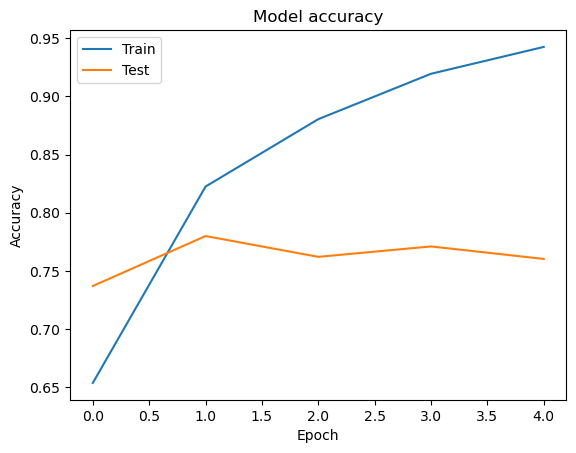

In [30]:
# Accuracy vs val_accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

model.save("E:\TA\web\Benda TA\model5.h5")
print('Save model to Disk')

from keras.models import load_model
model = load_model('model.h5')

# Test Menggunakan Data Uji

In [31]:
du = pd.read_csv(filepath_or_buffer='archive/Reddit_Combi.csv',sep=';',usecols=['Body_Title','label'])
du.head()

FileNotFoundError: [Errno 2] No such file or directory: 'archive/Reddit_Combi.csv'

In [ ]:
#Preprocessing
du['Body_Title'] = du['Body_Title'].apply(lambda x: preprocess_text(x))

In [ ]:
#Mengubah menjadi sequence

tokenizer.fit_on_texts(du["Body_Title"].values)
tokens = tokenizer.texts_to_sequences(du["Body_Title"].values)
tokens = pad_sequences(tokens, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
#Membuat prediksi
y_pred = model.predict(tokens)

In [ ]:
#Proses Membuat label Prediksi

labels = [1, 0]

prediction_labels=[]
for p in y_pred:
    print(p)
    prediction_labels.append(labels[np.argmax(p)])

In [ ]:
#Menghitung hasil prediksi dengan label 0

x = prediction_labels.count(0)
x

In [ ]:
#Menghitung hasil prediksi dengan label 1

y = prediction_labels.count(1)
y

In [ ]:
#Menampilkan hasil analisis sentimen

slices = [x, y]
activities = ['Negatif','Positif']
cols = ['orange','g']

plt.pie(slices,
        labels=activities,
        colors=cols,
        startangle=90,
        shadow= True,
        explode=(0,0.1),
        autopct='%0.2f%%')

plt.title('Sentiment RNN')
plt.plot
plt.savefig("rnn.png")
plt.show()